In [1]:
from keras.layers import Input, Conv2D, Dense,  Activation,Convolution2D,Conv2DTranspose, MaxPooling2D,BatchNormalization, UpSampling2D
from keras.models import Model
 

from keras.layers import Lambda,Add,Dropout,SpatialDropout2D,DepthwiseConv2D,normalization
from keras.models import Sequential, Model
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
import tensorflow as tf
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# aita die akta tensor e sob image k nie astasi

#from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D
import numpy as np
import os
from os.path import join
from pathlib import Path
import matplotlib.image as mpimg
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add
from keras.layers import LeakyReLU
from keras.layers import*
import cv2
import glob

In [2]:
def get_all_img(directory):
    images = sorted(os.listdir(os.path.join(directory)))  # os.listdir gives a list of all files name in this path
    #----- Here you get the directory id of each images from your folder.
    data = []
    #----- Here, you make a list.
    for image in images:
        data.append(mpimg.imread(os.path.join(directory, image)))

    return np.array(data)
    #----- Here, you are reading one by one image and appending to the list.
#And finally, np.save('X_img.npy',X)....you are saving it as np array.
def display(array1, array2):

    #Displays ten random images from each one of the supplied arrays.


    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.title("Hazy")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.title("Clean")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [3]:
X_train=[]
y_train=[]
X_train = get_all_img('RHazy/Hazy')
y_train = get_all_img('RGT/GT')

In [4]:
#Normalize them
xx_train = X_train/255.0
yy_train = y_train/255.0
print(xx_train.shape,yy_train.shape)

(76, 480, 640, 3) (76, 480, 640, 3)


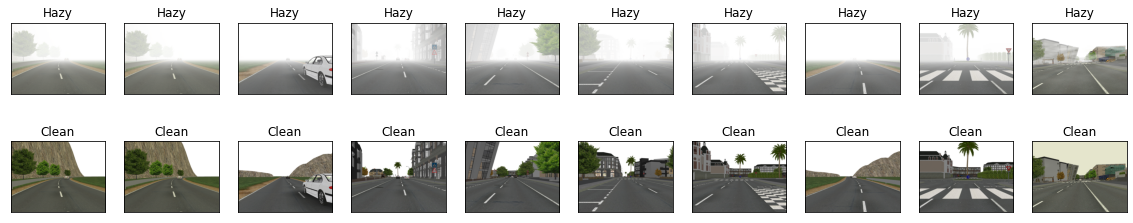

In [5]:
display(X_train,y_train)

In [6]:
def aug_haze(input_array, aug_mode):

  if aug_mode==1:
    # aug_mode = 1 means augmentation only applicable for the input hazy images
    aug1 = tf.image.flip_left_right(input_array)
    aug2 = tf.image.flip_up_down(input_array)
    aug3 = tf.image.rot90(input_array, k=2)
    # aug4 = tf.image.random_brightness(input_array, 0.4)
    # aug5 = tf.image.random_contrast (input_array, 0.25, 0.6)

  else:
    # aug_mode = any number except 1. means augmentation only applicable for the groundtruth images
    aug1 = tf.image.flip_left_right(input_array)
    aug2 = tf.image.flip_up_down(input_array)
    aug3 = tf.image.rot90(input_array, k=2)
    # aug4 = input_array
    # aug5 = input_array

  all_aug = tf.keras.layers.concatenate([input_array, aug1, aug2,aug3],0)

  return all_aug

In [7]:
X = aug_haze(X_train,1)
X.shape

2023-11-06 17:21:15.273959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 17:21:15.296611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 17:21:15.296738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 17:21:15.297210: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorShape([304, 480, 640, 3])

In [8]:
y = aug_haze(y_train,5)
y.shape

TensorShape([304, 480, 640, 3])

In [3]:
def plot_us(h, c):
    plt.figure(figsize=(8, 6))

    images = [h, c]
    titles = ['hazy', 'clean']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

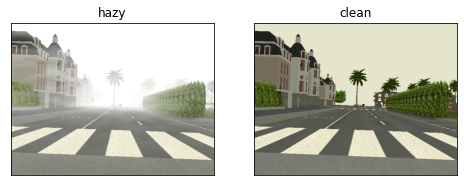

In [10]:
im_id = 0+84*1
plot_us(X[im_id],y[im_id])

In [11]:
#patches of 32 by 32 size

def patche(image, p_shape = (32, 32), stride = 20):
     p_list = list()
     h = image.shape[0]
     w = image.shape[1]
     img = tf.image.resize(image, [p_shape[0]*stride, p_shape[1]*stride])
     for i in range(stride):
       for j in range(stride):
         x = img[i*p_shape[0]:i*p_shape[0]+p_shape[0], j*p_shape[0]:j*p_shape[0]+p_shape[0]]
         p_list.append(x)
     return  np.asarray(p_list)

def tensor2patch(tnsr):
    p_haze=[]
    for i in range(len(tnsr)):
       p_haze.append(patche(tnsr[i]) )
    p_haze = np.array(p_haze)

    zape = p_haze.shape

    pr_haze = np.reshape(p_haze,[zape[0]*zape[1], zape[2], zape[3], zape[4]])
    return np.array(pr_haze)

In [12]:
HZ_x = tensor2patch(X)
HZ_y = tensor2patch(y)

In [13]:
HZ_x.shape

(121600, 32, 32, 3)

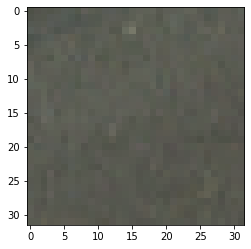

In [14]:
#plt.imshow(HZ_x[680])
plt.imshow(HZ_y[680])

In [4]:
# FUNCTIONS
def plot_sample(lr, sr,cr):
    plt.figure(figsize=(10, 12))

    images = [lr, sr,cr]
    titles = ['Hazy', 'Dehazed','Clear']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])


def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)

def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,max_val=1.0)

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def charbonnier_loss1(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3))) +   SSIMLoss(y_true, y_pred)

def msse(y_true, y_pred):

    return (tf.keras.losses.mse(y_true, y_pred))

def mssim(y_true, y_pred):
    y_pred = K.clip(y_pred,0,1)
    return (msse(y_true, y_pred)+SSIMLoss(y_true, y_pred))


In [5]:
def basic_conv(incoming_ftr, lcl_chnl, krnl ):
    x0 = Conv2D(lcl_chnl, kernel_size=krnl, strides=1, padding='same', activation='gelu')(incoming_ftr)
    x0 = Conv2D(lcl_chnl, kernel_size=krnl, strides=1, padding='same', activation='gelu')(x0)
    x0 = Conv2D(lcl_chnl, kernel_size=krnl, strides=1, padding='same', activation='gelu')(x0)
    return x0

def cheap_self_attn(incoming_ftr1):
    xa = tf.expand_dims(incoming_ftr1,1)
    xa = tf.reduce_mean(xa,2)
    xa = Activation('sigmoid')(xa)
    out_going =  Lambda(lambda x:x[0]*x[1] )([incoming_ftr1,xa])
    return out_going

def runt(x,f):
    y1 = Conv2D(f, kernel_size=3, strides=1, padding='same')(x)
    y1 = Conv2D(f, kernel_size=3, strides=1, padding='same')(y1)
    y2 = Conv2D(f//2, kernel_size=3, strides=1, padding='same')(y1)
    y2 = Conv2D(f//2, kernel_size=5, strides=1, padding='same')(y2)
    y3 = Conv2D(f//4, kernel_size=3, strides=1, padding='same')(y2)
    y3 = Conv2D(f//4, kernel_size=5, strides=1, padding='same')(y3)
    y4 = Conv2D(f//8, kernel_size=3, strides=1, padding='same')(y3)
    y4 = Conv2D(f//8, kernel_size=5, strides=1, padding='same')(y4)
    y5 = Conv2D(f//8, kernel_size=1, strides=1, padding='same')(y4)
    c1 = concatenate([y5,y4])
    y6 = Conv2D(f//4, kernel_size=1, strides=1, padding='same')(c1)
    c2 = concatenate([y6,y3])
    y7 = Conv2D(f//2, kernel_size=1, strides=1, padding='same')(c2)
    c3 = concatenate([y7,y2])
    y8 = Conv2D(f, kernel_size=1, strides=1, padding='same')(c3)
    y8 = add([y8,y1])
    y9 = Conv2D(f, kernel_size=1, strides=1, padding='same')(y8)
    return y9

def snake(y):
    return Lambda(lambda x:x+K.sin(x)*K.sin(x))(y)

def actc2(x):
    x1 = Activation('relu')(x)
    x3 = Activation('selu')(x)
    x5 = Activation('gelu')(x)

    c1 = Conv2D(9, kernel_size=3, strides=1, padding='same')( snake(x1))
    c2 = Conv2D(9, kernel_size=5, strides=1, padding='same')( snake(x3))
    c3 = Conv2D(9, kernel_size=7, strides=1, padding='same')( snake(x5))
    cx = add([c1,c2,c3 ] )

    cx = cheap_self_attn(cx)

    y= Conv2D(3, kernel_size=3, strides=1, padding='same')(cx)
    return y


def runatn(x,f):
    y1 = Conv2D(f, kernel_size=3, strides=1, padding='same')(x)
    y1 = Conv2D(f, kernel_size=3, strides=1, padding='same')(y1)
    y2 = Conv2D(f//2, kernel_size=3, strides=1, padding='same')(y1)
    y2 = Conv2D(f//2, kernel_size=5, strides=1, padding='same')(y2)
    y3 = Conv2D(f//4, kernel_size=3, strides=1, padding='same')(y2)
    y3 = Conv2D(f//4, kernel_size=5, strides=1, padding='same')(y3)
    y4 = Conv2D(f//8, kernel_size=3, strides=1, padding='same')(y3)
    y4 = Conv2D(f//8, kernel_size=5, strides=1, padding='same')(y4)
    y5 = Conv2D(f//8, kernel_size=1, strides=1, padding='same')(y4)
    c1 = concatenate([y5,y4,cheap_self_attn(y5)])
    y6 = Conv2D(f//4, kernel_size=1, strides=1, padding='same')(c1)
    c2 = concatenate([y6,y3,cheap_self_attn(y6)])
    y7 = Conv2D(f//2, kernel_size=1, strides=1, padding='same')(c2)
    c3 = concatenate([y7,y2, cheap_self_attn(y7)])
    y8 = Conv2D(f, kernel_size=1, strides=1, padding='same')(c3)
    y8 = add([y8,y1, cheap_self_attn(y8)])
    y9 = Conv2D(f, kernel_size=1, strides=1, padding='same')(y8)
    return y9

def rdn(x,f):
    y1 = Conv2D(f, kernel_size=3, strides=1, padding='same')(x)
    y2 = Conv2D(f, kernel_size=3, strides=1, padding='same')(y1)
    a1 = add([y1,y2])
    y3 = Conv2D(f, kernel_size=3, strides=1, padding='same')(a1)
    a2 = add([y3,a1])
    y4 = Conv2D(f, kernel_size=3, strides=1, padding='same')(a2)
    a3 = add([a1,a2,y4])
    a3  = concatenate([cheap_self_attn(a3),a3])
    csz  = concatenate([a1,a2,a3])
    return  Conv2D(f, kernel_size=3, strides=1, padding='same')(csz)


def krnl_conv(xyz, filters, kernl):
    x = Conv2D(filters,kernel_size=(kernl, kernl), strides = (1,1),  activation='gelu', padding="same")(xyz)
    return x

def uconv(tnsr, fltr, krnl):
    conv1 = Conv2D(fltr, kernel_size=(krnl, krnl), strides = (1,1), activation = 'relu',
                   padding = 'same', kernel_initializer = 'he_normal')(tnsr)

    conv1 = Conv2D(fltr, kernel_size=(krnl, krnl), strides = (1,1), activation = 'relu',
                   padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)
    return pool1

def mix_conv(tensr, filters):
    f1 = krnl_conv(tensr, filters, 1)
    f2 = krnl_conv(tensr, filters, 3)
    f3 = krnl_conv(tensr, filters, 5)
    f4 = krnl_conv(tensr, filters, 7)
    res = add([f1,f2,f3,f4])
    return res

def B_unt_ftr(ip,f):

    pool1 = uconv(ip, f, 3)
    pool2 = uconv(pool1, f*2, 3)
    pool3 = uconv(pool2, f*4, 3)
    pool4 = uconv(pool3, f*8, 3)
    conv5 = Conv2D( f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    u5=Conv2DTranspose(f, 3, strides=16,activation='relu', padding='same')(drop5)
    u5 = add([u5, mix_conv(u5,f)])
    u4=Conv2DTranspose(f, 3, strides=8,activation='relu', padding='same')(pool3)
    u4 = add([ u5, u4, mix_conv(u4,f)])
    u3=Conv2DTranspose(f, 3, strides=4,activation='relu', padding='same')(pool2)
    u3 = add([ u5, u4, u3,  mix_conv(u3,f)])
    u2=Conv2DTranspose(f, 3, strides=2,activation='relu', padding='same')(pool1)
    u2 = add([ u5, u4, u3, u2,  mix_conv(u2,f)])
    u1=Conv2DTranspose(f, 3, strides=1,activation='relu', padding='same')(ip)
    u1 = add([ u5, u4, u3, u2, u1, mix_conv(u1,f)])
    col = concatenate([u1,u2,u3,u4,u5], axis = 3)
    col = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(col)
    ip = Conv2D(3, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    sm = add([col,ip])
    return sm

In [6]:
def gunt(xoz):
    z = GlobalAveragePooling2D()(xoz)
    z = tf.expand_dims(z,1)
    z = tf.expand_dims(z,1)
    return z

def actc3(x):
    x1 = Activation('relu')(x)
    x3 = Activation('selu')(x)
    x5 = Activation('gelu')(x)
    cx = add([x1,x3,x5 ] )
    return cx

def EAM(input):

  x=Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
  x=Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)

  y=Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
  y=Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(y)

  z=Concatenate(axis=-1)([x,y])
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  add_1=Add()([z, input])

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
  z=Conv2D(64, (3,3),padding='same')(z)
  add_2=Add()([z,add_1])
  add_2 = Activation('relu')(add_2)

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (1,1),padding='same')(z)
  add_3=Add()([z,add_2])
  add_3 = Activation('relu')(add_3)

  z = GlobalAveragePooling2D()(add_3)
  z = tf.expand_dims(z,1)
  z = tf.expand_dims(z,1)
  z=Conv2D(4, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)

  mul=Multiply()([z, add_3])
  mul1 = actc3(mul)
  mul = add([mul,mul1])
  return mul


def mafe(x):
    x1 = Activation('relu')(x)
    x3 = Activation('selu')(x)
    x5 = Activation('gelu')(x)
    cx = add([x1,x3,x5 ] )
    cax = cheap_self_attn(cx)
    cox = add([cax,cx])
    return cox

In [7]:
input_img = Input(shape=(None,None,3))

lcl_chnl = 32
krnl = 3
input_img1 =  Lambda(lambda x: 1-x )(input_img)
input_img2 =  Lambda(lambda x: 3*x**2-2*x**3 )(input_img)

x1 =  basic_conv(input_img, lcl_chnl, krnl )
x2 =  basic_conv(input_img1, lcl_chnl, krnl )
x3 =  basic_conv(input_img2, lcl_chnl, krnl )
xs4 = add([x1,x2,x3])
ft1 =  runt(xs4,64)
ft2 =  actc2(xs4 )
ft3 =  rdn(xs4,128)
ft4 = runatn(xs4,64)
inp = concatenate([ft1,ft2,ft3, ft4, xs4])
x = Conv2D(3, 3,   strides=1, padding='same', activation='gelu')(inp)
model = Model(input_img, x)
#model.summary()

def RIDNET1():

  input = Input((None, None, 3),name='input')
  feat_extraction =Conv2D(64, (3,3),padding='same')(input)

  ft1 =  runt(feat_extraction,64)
  ft2 =  actc2(feat_extraction )
  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_2 = add([eam_2,eam_1])
  eam_3=EAM(eam_2)
  eam_3 = add([eam_2,eam_3])
  eam_4=EAM(eam_3)
  eam_4 = add([eam_4,eam_3])
  x=Conv2D(3, (3,3),padding='same')(eam_4)
  inp = concatenate([ft1,ft2,feat_extraction])

  x1 = Conv2D(3, 3,   strides=1, padding='same', activation='gelu')(inp)

  add_2=Add()([x,x1, input])

  model=Model(input,add_2)
  return model

def RIDNET():

  input = Input((None, None, 3),name='input')
  feat_extraction = mix_conv(input,64)


  input_img1 =  Lambda(lambda x: 1-x )(input)

  input_img2 =  Lambda(lambda x: 3*x**2-2*x**3 )(input)



  ft1 = mix_conv( input_img1,64)
  ft2 = mix_conv( input_img2,64)

  feat_extraction = add ([feat_extraction, ft1, mafe(ft2)])

  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_2 = add([eam_2,eam_1])
  eam_3=EAM(eam_2)
  eam_3 = add([eam_2,eam_3])
  eam_4=EAM(eam_3)
  eam_4 = add([eam_4,eam_3])
  x=Conv2D(3, (3,3),padding='same')(eam_4)


  add_2=Add()([x, input])

  model=Model(input,add_2)

  return model


model = RIDNET()

2023-11-07 15:43:53.792739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 15:43:53.844592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 15:43:53.844713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 15:43:53.845005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
from keras.losses import mean_absolute_error
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.4,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

filepath="Finalcode_Frida_21aug.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


Optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.1)

model.compile(loss=charbonnier_loss1, optimizer=Optimizer,    metrics=[psnr,ssim, "accuracy"])

In [32]:
history = model.fit(HZ_x, HZ_y,validation_split=0.2 , epochs=200, batch_size=32, callbacks = [checkpoint,reduce_lr], shuffle=True)


Epoch 1/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.7146 - psnr: 18.5638 - ssim: 0.7084 - accuracy: 0.5183
Epoch 1: val_loss improved from inf to 0.23189, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 157s 50ms/step - loss: 0.7144 - psnr: 18.5657 - ssim: 0.7084 - accuracy: 0.5182 - val_loss: 0.2319 - val_psnr: 25.6234 - val_ssim: 0.8533 - val_accuracy: 0.4914 - lr: 1.0000e-04
Epoch 2/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.2171 - psnr: 26.7587 - ssim: 0.8679 - accuracy: 0.5762
Epoch 2: val_loss improved from 0.23189 to 0.21124, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 151s 50ms/step - loss: 0.2171 - psnr: 26.7587 - ssim: 0.8679 - accuracy: 0.5762 - val_loss: 0.2112 - val_psnr: 29.6306 - val_ssim: 0.8652 - val_accuracy: 0.5008 - lr: 1.0000e-04
Epoch 3/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.1953 - psnr: 28.8717 - ssim: 0.88

Epoch 20/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.1234 - psnr: 34.2213 - ssim: 0.9262 - accuracy: 0.6597
Epoch 20: val_loss did not improve from 0.13676
3040/3040 [==============================] - 140s 46ms/step - loss: 0.1234 - psnr: 34.2204 - ssim: 0.9262 - accuracy: 0.6597 - val_loss: 0.1404 - val_psnr: 37.3595 - val_ssim: 0.9096 - val_accuracy: 0.6688 - lr: 1.0000e-04
Epoch 21/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.1221 - psnr: 34.3532 - ssim: 0.9270 - accuracy: 0.6637
Epoch 21: val_loss improved from 0.13676 to 0.13402, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 140s 46ms/step - loss: 0.1221 - psnr: 34.3535 - ssim: 0.9271 - accuracy: 0.6637 - val_loss: 0.1340 - val_psnr: 36.2633 - val_ssim: 0.9148 - val_accuracy: 0.6264 - lr: 1.0000e-04
Epoch 22/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.1203 - psnr: 34.5528 - ssim: 0.9282 - accuracy: 0.6547
Epoch 22: val_los

3040/3040 [==============================] - 140s 46ms/step - loss: 0.0940 - psnr: 36.9761 - ssim: 0.9451 - accuracy: 0.6760 - val_loss: 0.1118 - val_psnr: 37.1410 - val_ssim: 0.9288 - val_accuracy: 0.5779 - lr: 1.0000e-04
Epoch 59/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0933 - psnr: 37.1518 - ssim: 0.9455 - accuracy: 0.6762
Epoch 59: val_loss improved from 0.11177 to 0.11130, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0933 - psnr: 37.1524 - ssim: 0.9455 - accuracy: 0.6762 - val_loss: 0.1113 - val_psnr: 38.6818 - val_ssim: 0.9291 - val_accuracy: 0.5749 - lr: 1.0000e-04
Epoch 60/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0930 - psnr: 37.1214 - ssim: 0.9458 - accuracy: 0.6758
Epoch 60: val_loss did not improve from 0.11130
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0930 - psnr: 37.1207 - ssim: 0.9458 - accuracy: 0.6758 - val_loss: 0.1143 - va

Epoch 78/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0876 - psnr: 37.6856 - ssim: 0.9493 - accuracy: 0.6723
Epoch 78: val_loss did not improve from 0.10655
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0876 - psnr: 37.6855 - ssim: 0.9493 - accuracy: 0.6723 - val_loss: 0.1072 - val_psnr: 38.3993 - val_ssim: 0.9317 - val_accuracy: 0.5347 - lr: 1.0000e-04
Epoch 79/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0869 - psnr: 37.8499 - ssim: 0.9497 - accuracy: 0.6716
Epoch 79: val_loss did not improve from 0.10655
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0869 - psnr: 37.8504 - ssim: 0.9497 - accuracy: 0.6715 - val_loss: 0.1078 - val_psnr: 39.3569 - val_ssim: 0.9310 - val_accuracy: 0.7054 - lr: 1.0000e-04
Epoch 80/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0865 - psnr: 37.8805 - ssim: 0.9499 - accuracy: 0.6720
Epoch 80: val_loss did not improve from 0.10655
3040/3040 [======

Epoch 98/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0771 - psnr: 39.5569 - ssim: 0.9560 - accuracy: 0.6723
Epoch 98: val_loss did not improve from 0.10113

Epoch 98: ReduceLROnPlateau reducing learning rate to 1.5999999595806004e-05.
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0771 - psnr: 39.5550 - ssim: 0.9560 - accuracy: 0.6723 - val_loss: 0.1012 - val_psnr: 39.9606 - val_ssim: 0.9351 - val_accuracy: 0.6568 - lr: 4.0000e-05
Epoch 99/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0756 - psnr: 39.9886 - ssim: 0.9569 - accuracy: 0.6822
Epoch 99: val_loss improved from 0.10113 to 0.10055, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 141s 46ms/step - loss: 0.0756 - psnr: 39.9886 - ssim: 0.9569 - accuracy: 0.6822 - val_loss: 0.1005 - val_psnr: 41.1435 - val_ssim: 0.9354 - val_accuracy: 0.5666 - lr: 1.6000e-05
Epoch 100/200
3039/3040 [============================>.] - ETA: 0s - 

Epoch 117/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0730 - psnr: 40.4610 - ssim: 0.9586 - accuracy: 0.6886
Epoch 117: val_loss did not improve from 0.10002
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0730 - psnr: 40.4612 - ssim: 0.9586 - accuracy: 0.6886 - val_loss: 0.1000 - val_psnr: 41.0007 - val_ssim: 0.9356 - val_accuracy: 0.7285 - lr: 2.5600e-06
Epoch 118/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0730 - psnr: 40.4609 - ssim: 0.9586 - accuracy: 0.6864
Epoch 118: val_loss improved from 0.10002 to 0.10001, saving model to Finalcode_Frida_21aug.hdf5
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0730 - psnr: 40.4613 - ssim: 0.9586 - accuracy: 0.6864 - val_loss: 0.1000 - val_psnr: 41.3481 - val_ssim: 0.9356 - val_accuracy: 0.7249 - lr: 2.5600e-06
Epoch 119/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0730 - psnr: 40.4672 - ssim: 0.9587 - accuracy: 0.6901
Epoch 119: v

Epoch 137/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0727 - psnr: 40.5220 - ssim: 0.9588 - accuracy: 0.6964
Epoch 137: val_loss did not improve from 0.09999
3040/3040 [==============================] - 142s 47ms/step - loss: 0.0727 - psnr: 40.5220 - ssim: 0.9588 - accuracy: 0.6964 - val_loss: 0.1000 - val_psnr: 41.0960 - val_ssim: 0.9356 - val_accuracy: 0.6658 - lr: 1.6384e-07
Epoch 138/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0727 - psnr: 40.5432 - ssim: 0.9588 - accuracy: 0.6939
Epoch 138: val_loss did not improve from 0.09999
3040/3040 [==============================] - 142s 47ms/step - loss: 0.0727 - psnr: 40.5445 - ssim: 0.9588 - accuracy: 0.6939 - val_loss: 0.1000 - val_psnr: 41.0846 - val_ssim: 0.9356 - val_accuracy: 0.6524 - lr: 1.6384e-07
Epoch 139/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0727 - psnr: 40.5227 - ssim: 0.9588 - accuracy: 0.6945
Epoch 139: val_loss did not improve from 0.09999
3040/3040 [

Epoch 157/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5375 - ssim: 0.9589 - accuracy: 0.6948
Epoch 157: val_loss did not improve from 0.09999
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0726 - psnr: 40.5374 - ssim: 0.9589 - accuracy: 0.6949 - val_loss: 0.1000 - val_psnr: 41.0835 - val_ssim: 0.9356 - val_accuracy: 0.6754 - lr: 1.0486e-08
Epoch 158/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5336 - ssim: 0.9589 - accuracy: 0.6939
Epoch 158: val_loss did not improve from 0.09999

Epoch 158: ReduceLROnPlateau reducing learning rate to 4.194303571125602e-09.
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0726 - psnr: 40.5327 - ssim: 0.9589 - accuracy: 0.6939 - val_loss: 0.1000 - val_psnr: 41.0863 - val_ssim: 0.9356 - val_accuracy: 0.6750 - lr: 1.0486e-08
Epoch 159/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0726 - psnr: 40.5369 - ssim: 0.9589 

Epoch 177/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5370 - ssim: 0.9589 - accuracy: 0.6935
Epoch 177: val_loss did not improve from 0.09999
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6935 - val_loss: 0.1000 - val_psnr: 41.0854 - val_ssim: 0.9356 - val_accuracy: 0.6753 - lr: 2.6844e-10
Epoch 178/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5364 - ssim: 0.9589 - accuracy: 0.6936
Epoch 178: val_loss did not improve from 0.09999
3040/3040 [==============================] - 140s 46ms/step - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6936 - val_loss: 0.1000 - val_psnr: 41.0854 - val_ssim: 0.9356 - val_accuracy: 0.6756 - lr: 2.6844e-10
Epoch 179/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6937
Epoch 179: val_loss did not improve from 0.09999
3040/3040 [

Epoch 197/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5357 - ssim: 0.9589 - accuracy: 0.6935
Epoch 197: val_loss did not improve from 0.09999
3040/3040 [==============================] - 142s 47ms/step - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6935 - val_loss: 0.1000 - val_psnr: 41.0854 - val_ssim: 0.9356 - val_accuracy: 0.6753 - lr: 1.7180e-11
Epoch 198/200
3040/3040 [==============================] - ETA: 0s - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6935
Epoch 198: val_loss did not improve from 0.09999
3040/3040 [==============================] - 141s 46ms/step - loss: 0.0726 - psnr: 40.5355 - ssim: 0.9589 - accuracy: 0.6935 - val_loss: 0.1000 - val_psnr: 41.0854 - val_ssim: 0.9356 - val_accuracy: 0.6753 - lr: 1.7180e-11
Epoch 199/200
3039/3040 [============================>.] - ETA: 0s - loss: 0.0726 - psnr: 40.5354 - ssim: 0.9589 - accuracy: 0.6935
Epoch 199: val_loss did not improve from 0.09999
3040/3040 [

In [9]:
 model.load_weights('40psnr.h5')

In [35]:
o1 = HZ_x[:32]

In [36]:
o2 = model.predict(o1)

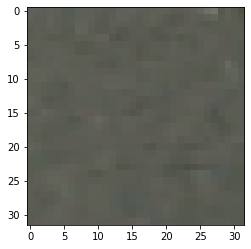

In [43]:
plt.imshow(HZ_y[347] )

In [10]:
from glob import glob

datat = np.array(glob('hzt/*'))

2023-11-07 15:44:18.555545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


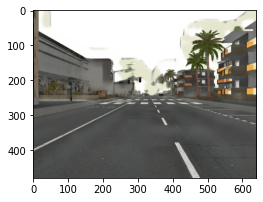

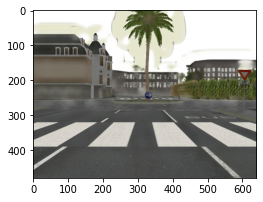

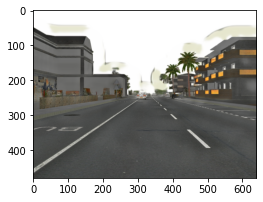

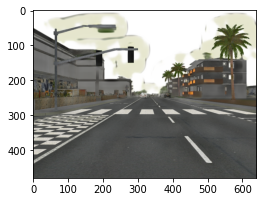

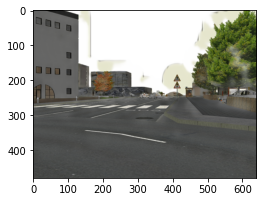

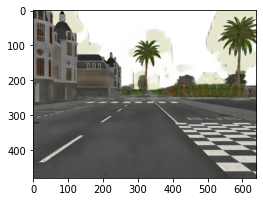

In [11]:
for co in range (len(datat )):
    ar= cv2.imread(datat[co])
    a = cv2.cvtColor(ar, cv2.COLOR_BGR2RGB)/255
    b = np.expand_dims(a,0)
    c = model.predict(b)
    plt.figure(figsize=(4,4))
    plt.imshow(c[0])

In [56]:
def pgy(parameters, gradients ):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
 
        ap = 5e-1
        gt = (1-ap)*   (grads)  +(ap*params)
        new_grads.append( (gt)  )
    return new_grads 



def test_nup0(mofel,hzy_img,hz_lvl):
    
    hg1 = hzy_img**hz_lvl
    hg2 = hg1**hz_lvl
    ewt = mofel.get_weights()
    #mo1 = Model(input_img, x)
    mo1 = mofel
    mo1.set_weights(ewt)
    dhz0 = mofel.predict(hzy_img)
    dhz1 = mofel.predict(hg1)
    tdhz = 3*dhz0**2 - 2*dhz0**3
    tdhz = (tdhz + dhz1)/2
    
    for i in range(5):
    
        with tf.GradientTape(persistent=True) as tape:

                dz = hg2**hz_lvl-hg2
                to1 = (mo1(hg2**hz_lvl, training=True) )
                to2 = (mo1(hg2+dz, training=True) )
 
                loj = msse(dhz0,to1) + msse(dhz1,to2) + msse(tdhz,to2) 
 
                            
    
        grads =   (tape.gradient(loj, mo1.trainable_weights))
 
        optimizer.apply_gradients(zip(grads, mo1.trainable_weights))
        ko1 = mo1.get_weights()
        ko1 = pgy(ewt,ko1)
        mo1.set_weights(ko1) 
    frp = np.clip ( (mo1.predict(hzy_img)) ,0,1)
        #ng2 = (ng2+to1)/2
    
 
    
    return frp

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)


def plot_sample(lr, sr,cr):
    plt.figure(figsize=(10, 12))

    images = [lr, sr,cr]
    titles = ['Hazy', 'Dehazed','Dehazed_plus']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])


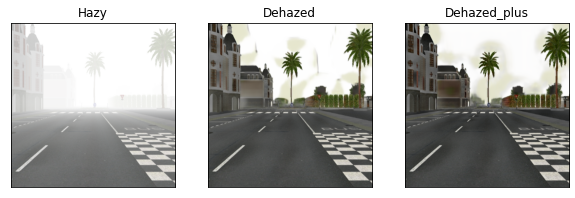

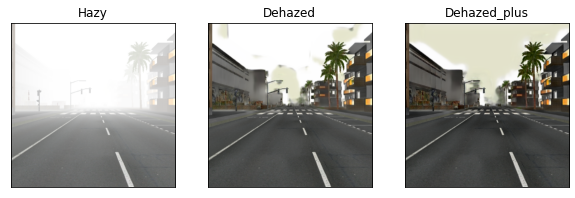

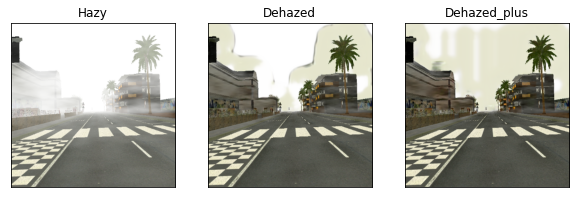

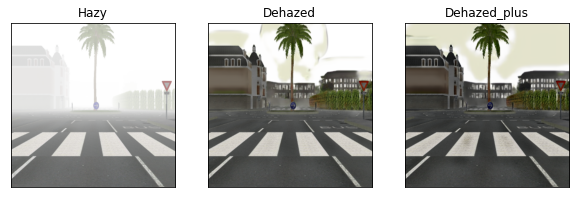

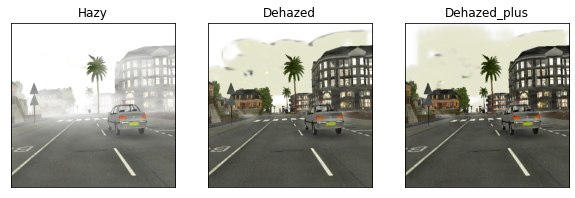

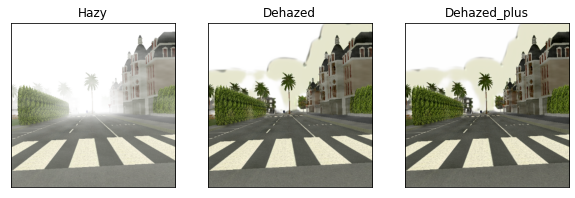

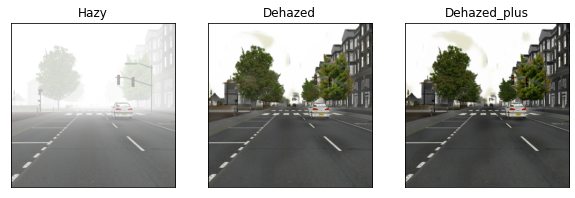

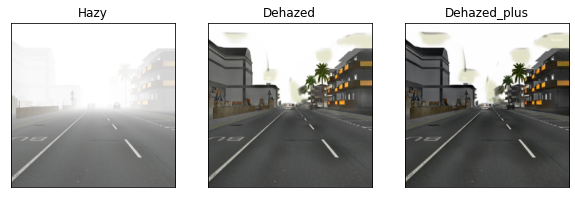

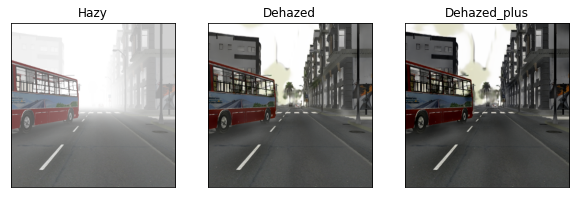

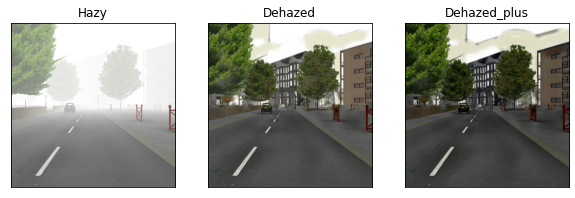

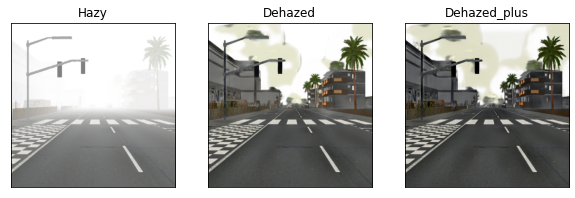

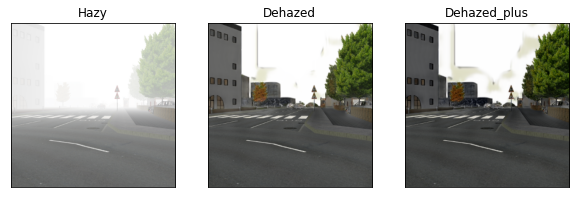

In [58]:
from glob import glob

datat = np.array(glob('hzt/*'))
 

for co in range (len(datat )):
    ar= cv2.imread(datat[co])
    hzy_img = cv2.cvtColor(ar, cv2.COLOR_BGR2RGB)/255
    hzy_img = np.expand_dims(hzy_img,0)
    dmm = 356
    hzy_img = tf.image.resize(hzy_img,[dmm,dmm])
    
    model.load_weights('40psnr.h5')
    cln = model.predict(hzy_img)
    hz_lvl = 0.15
    cln_plus = test_nup0(model,hzy_img,hz_lvl)
    cln = np.clip(cln,0 ,1)
    cln_plus = np.clip(cln_plus,0 ,1)
    plot_sample(hzy_img[0], cln[0],cln_plus[0])
    
    
    
#     plt.figure(figsize=(4,4))
#     plt.imshow(c[0])

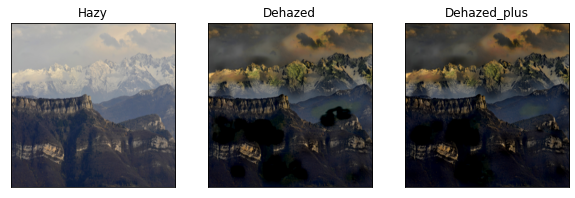

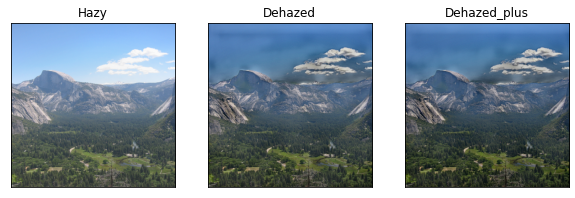

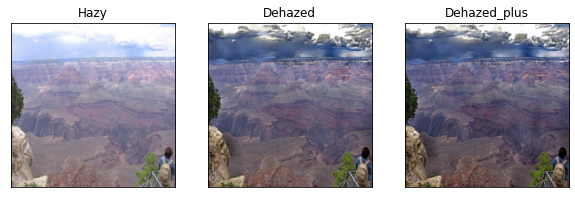

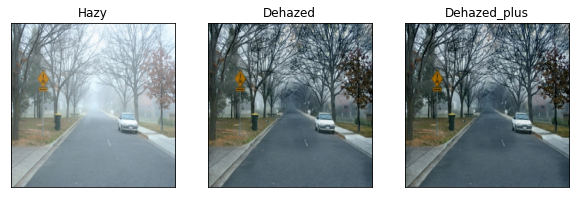

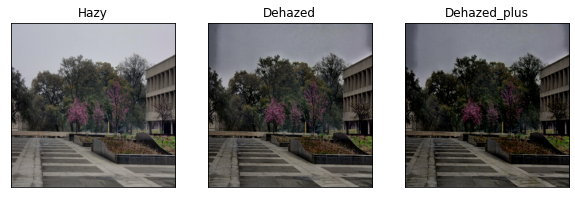

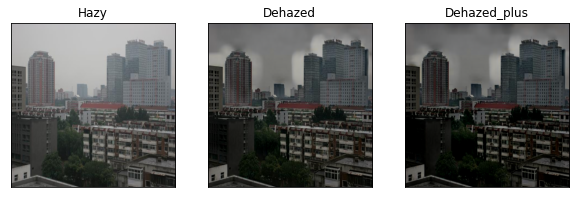

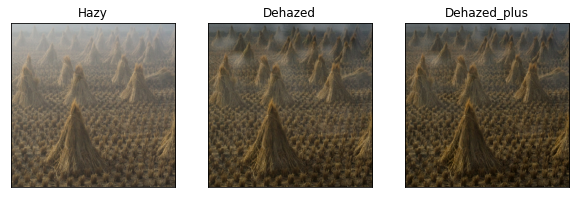

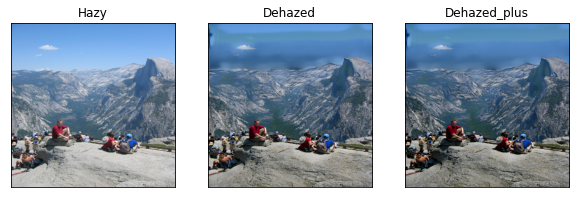

In [59]:
datat = np.array(glob('nogthz/*'))

for co in range (len(datat )):
    ar= cv2.imread(datat[co])
    hzy_img = cv2.cvtColor(ar, cv2.COLOR_BGR2RGB)/255
    hzy_img = np.expand_dims(hzy_img,0)
    dmm = 356
    hzy_img = tf.image.resize(hzy_img,[dmm,dmm])
    
    model.load_weights('40psnr.h5')
    cln = model.predict(hzy_img)
    hz_lvl = 0.85
    cln_plus = test_nup0(model,hzy_img,hz_lvl)
    cln = np.clip(cln,0 ,1)
    cln_plus = np.clip(cln_plus,0 ,1)
    plot_sample(hzy_img[0], cln[0],cln_plus[0])
    